In [6]:
%%capture --no-stderr
!uv pip install -U langgraph langsmith langchain_anthropic langchain_openai
!uv pip install -U duckduckgo-search

Using Python 3.12.9 environment at: C:\Users\Leon\Documents\GitHub\agents\.venv
Resolved 41 packages in 437ms
Prepared 26 packages in 17ms
Uninstalled 5 packages in 143ms
Installed 26 packages in 480ms
 + anthropic==0.49.0
 - anyio==4.8.0
 + anyio==4.9.0
 + jsonpatch==1.33
 + jsonpointer==3.0.0
 + langchain-anthropic==0.3.10
 + langchain-core==0.3.49
 + langchain-openai==0.3.11
 + langgraph==0.3.22
 + langgraph-checkpoint==2.0.23
 + langgraph-prebuilt==0.1.7
 + langgraph-sdk==0.1.60
 + langsmith==0.3.22
 - openai==1.66.3
 + openai==1.70.0
 + orjson==3.10.16
 + ormsgpack==1.9.1
 - pydantic==2.10.6
 + pydantic==2.11.1
 - pydantic-core==2.27.2
 + pydantic-core==2.33.0
 + pyyaml==6.0.2
 + regex==2024.11.6
 + requests-toolbelt==1.0.0
 + tenacity==9.0.0
 + tiktoken==0.9.0
 - typing-extensions==4.12.2
 + typing-extensions==4.13.0
 + typing-inspection==0.4.0
 + xxhash==3.5.0
 + zstandard==0.23.0
Using Python 3.12.9 environment at: C:\Users\Leon\Documents\GitHub\agents\.venv
Resolved 5 packages

In [7]:
import os
import uuid
from datetime import datetime
from typing import Annotated, Callable, Literal, Optional

import requests
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv, set_key
from duckduckgo_search import DDGS
from IPython.display import Image, display
from langchain_core.messages import ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

load_dotenv()
# Get values from environment variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_MODEL = os.getenv("AZURE_OPENAI_MODEL")
AZURE_AD_TOKEN_SCOPE = os.getenv("AZURE_AD_TOKEN_SCOPE")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
BACKEND_DB_URL = os.getenv("BACKEND_DB_URL")

In [8]:
# login
login_data = {
    "grant_type": "password",  # Required
    "username": "kimberly.garza@example.net",  # Email used for login
    "password": "abc123",  # Password used for login
    "scope": "",  # Optional (empty value sent)
    "client_id": "",  # Optional (empty value sent)
    "client_secret": "",  # Optional (empty value sent)
}


def login(login_data):
    login_url = f"{BACKEND_DB_URL}/login"
    try:
        response = requests.post(login_url, data=login_data)
        auth_token = response.json().get("access_token")

        if auth_token:
            print("Access token received.")
            os.environ["AUTH_TOKEN"] = auth_token
            set_key(".env", "AUTH_TOKEN", auth_token)

            print("Access token saved to environment.")
    except Exception as e:
        print("Failed to login user:", e)


login(login_data)

Access token received.
Access token saved to environment.


In [22]:
# Tools


@tool
def duckduckgo_search(query: str) -> list[dict[str, str]]:
    """Perform a web search using DuckDuckGo"""
    print(f"[DEBUG[TOOL]] duckduckgo_search: Received query: {query}")
    with DDGS() as ddgs:
        results = ddgs.text(query, max_results=3)
    print(f"[DEBUG][TOOL] duckduckgo_search: Results obtained: {results}")
    return results


@tool
def get_user_profile(config: RunnableConfig):
    """
    Fetch user's information.

    Returns:
        dict: A dictionary containing user's information.
    """
    print("[DEBUG][TOOL] get_user_profile: Starting profile lookup.")
    try:
        # Retrieve user_id from the configuration
        auth_token = config.get("configurable", {}).get("auth_token")
        if not auth_token:
            print("[DEBUG][TOOL] get_user_profile: user_auth_token is missing.")
            return {"error": "user_auth_token is missing in the configuration."}

        # Construct the API endpoint URL
        url = BACKEND_DB_URL + "/users/"
        print(f"[DEBUG][TOOL] get_user_profile: URL constructed: {url}")
        header = {
            "Authorization": f"Bearer {auth_token}",
            "Content-Type": "application/json",
        }
        response = requests.get(url, headers=header)
        print(
            f"[DEBUG][TOOL] get_user_profile: Response status code: {response.status_code}"
        )

        if response.status_code == 200:
            user = response.json()
            print(f"[DEBUG][TOOL] get_user_profile: User data received: {user}")
            return (user,)
        else:
            print(
                f"[DEBUG][TOOL] get_user_profile: Failed to fetch user data. Status code: {response.status_code}"
            )
            return {
                "error": f"Failed to fetch user data. Status code: {response.status_code}"
            }

    except Exception as e:
        print(f"[DEBUG][TOOL] get_user_profile: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}


@tool
def get_available_bookings(
    config: RunnableConfig,
    vaccine_name: str,
    polyclinic_name: str | None = None,
    start_datetime: str | None = None,
    end_datetime: str | None = None,
    polyclinic_limit: int = 3,
    timeslot_limit: int = 1,
) -> list[dict]:
    """
    Fetch available booking slots for a specific vaccine and polyclinic within a specific date range.

    Args:
        vaccine_name (str): The name of the vaccine to check availability for.
        polyclinic_name (str | None, optional): The name of the polyclinic. Defaults to None.
        start_datetime (str | None, optional): The start date or datetime. Defaults to None.
        end_datetime (str | None, optional): The end date or datetime. Defaults to None.
        polyclinic_limit (int, optional): The maximum number of polyclinics to return. Defaults to 3.
        timeslot_limit (int, optional): The maximum number of timeslots to return. Defaults to 1.

    Returns:
        list[dict]: A list of dictionaries containing booking slot information.
    """
    print("[DEBUG][TOOL] get_available_bookings: Starting available bookings lookup.")
    try:
        # Retrieve the authentication token from the configuration
        auth_token = config.get("configurable", {}).get("auth_token")
        if not auth_token:
            print("[DEBUG][TOOL] get_available_bookings: user_auth_token is missing.")
            return {"error": "user_auth_token is missing in the configuration."}

        # Retrieve booking parameters from the configuration
        # The vaccine_name passed as a function parameter is used as the default value.
        vaccine_name = vaccine_name
        polyclinic_limit = 3
        timeslot_limit = 1

        # Construct the API endpoint URL for bookings
        url = BACKEND_DB_URL + "/bookings/available"
        print(f"[DEBUG][TOOL] get_available_bookings: URL constructed: {url}")

        # Prepare query parameters using the validated booking_request data.
        # Note that booking_request.vaccine_name is an Enum, so we use its .value.
        params = {
            "vaccine_name": vaccine_name,
            "polyclinic_name": polyclinic_name,
            "start_datetime": start_datetime,
            "end_datetime": end_datetime,
            "polyclinic_limit": polyclinic_limit,
            "timeslot_limit": timeslot_limit,
        }

        # Set up the request header with the authentication token
        headers = {
            "Authorization": f"Bearer {auth_token}",
            "Content-Type": "application/json",
        }

        # Make the GET request to the bookings API endpoint
        response = requests.get(url, headers=headers, params=params)
        print(
            f"[DEBUG][TOOL] get_available_bookings: Response status code: {response.status_code}"
        )

        # Check for a successful response and process the returned data
        # Check for a successful response and process the returned data
        if response.status_code == 200:
            available_bookings = response.json()
            # If data is a list, use it directly; otherwise, attempt to retrieve "available_bookings"
            # if isinstance(data, list):
            #     available_bookings = data
            # else:
            #     available_bookings = data.get("available_bookings", data)
            print(
                f"[DEBUG][TOOL] get_available_bookings: Bookings data received: {available_bookings}"
            )
            return (available_bookings,)

        else:
            print(
                f"[DEBUG][TOOL] get_available_bookings: Failed to fetch available bookings. Status code: {response.status_code}"
            )
            return {
                "error": f"Failed to fetch available bookings. Status code: {response.status_code}"
            }

    except Exception as e:
        print(f"[DEBUG][TOOL] get_available_bookings: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}


@tool
def schedule_booking(
    booking_slot_id: str,
    *,
    config: RunnableConfig,
):
    """
    Schedules a vaccination slot for the user.

    Args:
        booking_slot_id (str): The booking slot ID.

    Returns:
        dict: A dictionary containing the scheduled vaccination slot information.
    """
    print("[DEBUG][TOOL] schedule_booking: Starting booking scheduling process.")
    try:
        # Retrieve the authentication token from the configuration
        auth_token = config.get("configurable", {}).get("auth_token")
        if not auth_token:
            print("[DEBUG][TOOL] schedule_booking: user_auth_token is missing.")
            return {"error": "user_auth_token is missing in the configuration."}

        # Construct the API endpoint URL for scheduling the booking
        url = BACKEND_DB_URL + "/bookings/schedule"
        print(f"[DEBUG][TOOL] schedule_booking: URL constructed: {url}")
        print(f"[DEBUG][TOOL] schedule_booking: Booking slot ID: {booking_slot_id}")

        # Prepare the POST request payload
        payload = {"booking_slot_id": booking_slot_id}

        # Set up the request headers with the authentication token
        headers = {
            "Authorization": f"Bearer {auth_token}",
            "Content-Type": "application/json",
        }

        # Make the POST request to the scheduling endpoint
        response = requests.post(url, headers=headers, json=payload)
        print(
            f"[DEBUG][TOOL] schedule_booking: Response status code: {response.status_code}"
        )

        # Process the response
        if response.status_code == 200 or response.status_code == 201:
            data = response.json()
            print(
                f"[DEBUG][TOOL] schedule_booking: Booking scheduled successfully: {data}"
            )
            return (data,)
        else:
            print(
                f"[DEBUG][TOOL] schedule_booking: Failed to schedule booking. Status code: {response.status_code}"
            )
            return {
                "error": f"Failed to schedule booking. Status code: {response.status_code}"
            }

    except Exception as e:
        print(f"[DEBUG][TOOL] schedule_booking: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}


@tool
def general_ai(input_data: str) -> dict[str, str]:
    """Ask me about any health-relatd stuff, my role is to Provide health-related AI insights."""
    print(f"[DEBUG][TOOL] general_ai: Received input_data: {input_data}")
    result = {"analysis": "Health insights generated successfully"}
    print(f"[DEBUG][TOOL] general_ai: Analysis result: {result}")
    return result


@tool
def get_user_vaccine_records(config: RunnableConfig):
    """
    Fetch user's vaccination records.

    Returns:
        list[dict]: A list of dictionaries containing vaccination record information. A vaccination record status can be 'booked' (but pending) or 'completed'.
    """
    print(
        "[DEBUG][TOOL] get_user_vaccine_records: Starting retrieval of vaccine records."
    )
    try:
        # Retrieve auth_token from the configuration
        auth_token = config.get("configurable", {}).get("auth_token")
        if not auth_token:
            print("[DEBUG][TOOL] get_user_vaccine_records: auth_token is missing.")
            return {"error": "auth_token is missing in the configuration."}

        # Construct the API endpoint URL
        url = BACKEND_DB_URL + "/records"
        print(f"[DEBUG][TOOL] get_user_vaccine_records: URL constructed: {url}")
        headers = {
            "Authorization": f"Bearer {auth_token}",
            "Content-Type": "application/json",
        }
        response = requests.get(url, headers=headers)
        print(
            f"[DEBUG][TOOL] get_user_vaccine_records: Response status code: {response.status_code}"
        )

        if response.status_code == 200:
            records = response.json()
            print(
                f"[DEBUG][TOOL] get_user_vaccine_records: Records received: {records}"
            )
            return records
        else:
            print(
                f"[DEBUG][TOOL] get_user_vaccine_records: Failed with status code: {response.status_code}"
            )
            return {
                "error": f"Failed to fetch vaccine records. Status code: {response.status_code}"
            }

    except Exception as e:
        print(f"[DEBUG][TOOL] get_user_vaccine_records: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}


@tool
def get_vaccine_recommendations(config: RunnableConfig):
    """
    Fetch vaccines user's are eligible for.

    Returns:
        list[dict]: A list of dictionaries containing vaccine information.
    """
    print("[DEBUG][TOOL] get_vaccine_recommendation: Starting recommendation process.")
    try:
        # Retrieve auth_token from the configuration
        auth_token = config.get("configurable", {}).get("auth_token")
        if not auth_token:
            print("[DEBUG][TOOL] get_vaccine_recommendation: auth_token is missing.")
            return {"error": "auth_token is missing in the configuration."}

        # Construct the API endpoint URL
        url = BACKEND_DB_URL + "/vaccines/recommendations"
        print(f"[DEBUG][TOOL] get_vaccine_recommendation: URL constructed: {url}")
        headers = {
            "Authorization": f"Bearer {auth_token}",
            "Content-Type": "application/json",
        }
        response = requests.get(url, headers=headers)
        print(
            f"[DEBUG][TOOL] get_vaccine_recommendation: Response status code: {response.status_code}"
        )

        if response.status_code == 200:
            recommendations = response.json()
            print(
                f"[DEBUG][TOOL] get_vaccine_recommendation: Recommendations received: {recommendations}"
            )
            return (recommendations,)

        else:
            print(
                f"[DEBUG][TOOL] get_vaccine_recommendation: Failed with status code: {response.status_code}"
            )
            return {
                "error": f"Failed to fetch vaccine recommendations. Status code: {response.status_code}"
            }

    except Exception as e:
        print(f"[DEBUG][TOOL] get_vaccine_recommendation: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}

In [23]:
# Utility functions


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [24]:
def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "ask_general",
                "check_vaccination",
                "book_appointment",
            ]
        ],
        update_dialog_stack,
    ]

In [25]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            auth_token = configuration.get("auth_token", None)
            state = {**state, "auth_token": auth_token}
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's profile for more information.",
            },
        }


# General AI Assistant
ask_general_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for answering health-related queries. "
            "You use two primary tools: a web search engine (DuckDuckGo) for general health-related information and a specialized HealthHub chatbot for specific health-related queries. "
            "When searching, prioritize accuracy and reliability. Use DuckDuckGo for general health information and escalate to the HealthHub chatbot for more detailed or personalized queries. "
            "Always ensure that the information you provide is up-to-date and relevant to the user's query."
            "\n\nCurrent auth_token for this user:\n<auth_token>\n{auth_token}\n</auth_token>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and neither DuckDuckGo nor the HealthHub chatbot can provide an answer, escalate the task back to the main assistant. "
            "Do not waste the user's time. Do not make up invalid tools or functions.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(credential, AZURE_AD_TOKEN_SCOPE)

llm = AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_MODEL,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_ad_token_provider=token_provider,
    temperature=0.0,
)
ask_general_safe_tools = [duckduckgo_search, general_ai]
ask_general_sensitive_tools = []
ask_general_tools = ask_general_safe_tools + ask_general_sensitive_tools
ask_general_runnable = ask_general_prompt | llm.bind_tools(
    ask_general_tools + [CompleteOrEscalate]
)

# Vaccination Booking Assistant
book_appointment_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling vaccination bookings. "
            "The primary assistant delegates work to you whenever the user needs help scheduling a vaccination appointment or check for available booking appointments. "
            "Search for available booking slots based on the user's preferences and confirm the booking details with the customer. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            "Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'Can you explain how vaccines work?'\n"
            " - 'Actually, I want to consult my doctor first.'\n"
            " - 'I need to book an appointment for my child instead.'\n"
            " - 'What are the side effects of this vaccine?'\n"
            " - 'Vaccination appointment confirmed.'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_appointment_safe_tools = [get_available_bookings]
book_appointment_sensitive_tools = [schedule_booking]
book_appointment_tools = book_appointment_safe_tools + book_appointment_sensitive_tools
book_appointment_runnable = book_appointment_prompt | llm.bind_tools(
    book_appointment_tools + [CompleteOrEscalate]
)

# Vaccination Agent

check_vaccination_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling vaccination records and recommending vaccines to users based on their health profiles. "
            "The primary assistant delegates work to you whenever the user needs help accessing their vaccination records or their recommended vaccines. "
            "Retrieve the user's vaccination history and recommendations. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "Remember that providing accurate information is your top priority."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'I need to book an appointment instead.'\n"
            " - 'Can you explain how vaccines work?'\n"
            " - 'Can you check the available booking slots for me?'\n"
            " - 'Actually, I want to consult my doctor first.'\n",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

check_vaccination_safe_tools = [get_user_vaccine_records]
check_vaccination_sensitive_tools = [get_vaccine_recommendations]
check_vaccination_tools = (
    check_vaccination_safe_tools + check_vaccination_sensitive_tools
)
check_vaccination_runnable = check_vaccination_prompt | llm.bind_tools(
    check_vaccination_tools + [CompleteOrEscalate]
)


class ToVaccinationAgent(BaseModel):
    """Transfers work to a specialized assistant to handle vaccination records and recommendations."""

    request: str = Field(
        description="Any specific questions or requests regarding vaccination records or vaccine recommendations."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "request": "Can you check my vaccination records and recommend any vaccines I might need?",
            }
        }


class ToGeneralAgent(BaseModel):
    """Transfers work to a specialized assistant to handle general health-related queries."""

    query: str = Field(
        description="The health-related query the user wants assistance with."
    )
    context: Optional[str] = Field(
        description="Additional context or information provided by the user to help answer their query.",
        default=None,
    )

    class Config:
        json_schema_extra = {
            "example": {
                "query": "What are the benefits of the Hepatitis B vaccine?",
                "context": "I am 35 years old and planning to travel abroad.",
            }
        }


class ToBookingAgent(BaseModel):
    """Transfers work to a specialized assistant to handle vaccination appointment bookings."""

    vaccine_name: str = Field(
        description="The name of the vaccine the user wants to book an appointment for."
    )
    # preferred_date: Optional[str] = Field(
    #     description="The user's preferred date for the vaccination appointment.",
    #     default=None,
    # )
    # location: Optional[str] = Field(
    #     description="The location where the user wants to book their vaccination appointment.",
    #     default=None,
    # )
    request: str = Field(
        description="Any additional information or requests from the user regarding the booking."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "vaccine_name": "Hepatitis B (HepB)",
                # "preferred_date": "2025-04-05",
                # "location": "HealthHub Clinic, Downtown",
                "request": "I need an early morning slot if available.",
            }
        }


llm = AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_MODEL,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_ad_token_provider=token_provider,
    temperature=0.0,
)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for HealthHub. "
            "Your primary role is to assist users with general health-related queries, vaccination-related tasks, and appointment bookings. "
            "If a customer requests to check vaccination records or get vaccine recommendations, book a vaccination appointment, or has general health-related questions, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent auth_token for this user:\n<auth_token>\n{auth_token}\n</auth_token>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)
primary_assistant_tools = [get_user_profile]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToBookingAgent,
        ToVaccinationAgent,
        ToGeneralAgent,
    ]
)

In [26]:
def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [27]:
builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": get_user_profile.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [28]:
# Vaccination assistant
builder.add_node(
    "enter_check_vaccination",
    create_entry_node("Vaccination Assistant", "check_vaccination"),
)
builder.add_node("check_vaccination", Assistant(check_vaccination_runnable))
builder.add_edge("enter_check_vaccination", "check_vaccination")
builder.add_node(
    "check_vaccination_sensitive_tools",
    create_tool_node_with_fallback(check_vaccination_sensitive_tools),
)
builder.add_node(
    "check_vaccination_safe_tools",
    create_tool_node_with_fallback(check_vaccination_safe_tools),
)


def route_check_vaccination(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in check_vaccination_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "check_vaccination_safe_tools"
    return "check_vaccination_sensitive_tools"


builder.add_edge("check_vaccination_sensitive_tools", "check_vaccination")
builder.add_edge("check_vaccination_safe_tools", "check_vaccination")
builder.add_conditional_edges(
    "check_vaccination",
    route_check_vaccination,
    [
        "check_vaccination_sensitive_tools",
        "check_vaccination_safe_tools",
        "leave_skill",
        END,
    ],
)

In [29]:
# Booking assistant

builder.add_node(
    "enter_book_appointment",
    create_entry_node("Booking Assistant", "book_appointment"),
)
builder.add_node("book_appointment", Assistant(book_appointment_runnable))
builder.add_edge("enter_book_appointment", "book_appointment")
builder.add_node(
    "book_appointment_safe_tools",
    create_tool_node_with_fallback(book_appointment_safe_tools),
)
builder.add_node(
    "book_appointment_sensitive_tools",
    create_tool_node_with_fallback(book_appointment_sensitive_tools),
)


def route_book_appointment(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_appointment_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_appointment_safe_tools"
    return "book_appointment_sensitive_tools"


builder.add_edge("book_appointment_sensitive_tools", "book_appointment")
builder.add_edge("book_appointment_safe_tools", "book_appointment")
builder.add_conditional_edges(
    "book_appointment",
    route_book_appointment,
    [
        "book_appointment_safe_tools",
        "book_appointment_sensitive_tools",
        "leave_skill",
        END,
    ],
)

In [30]:
# General assistant
builder.add_node(
    "enter_ask_general",
    create_entry_node("General Assistant", "ask_general"),
)
builder.add_node("ask_general", Assistant(ask_general_runnable))
builder.add_edge("enter_ask_general", "ask_general")
builder.add_node(
    "ask_general_safe_tools",
    create_tool_node_with_fallback(ask_general_safe_tools),
)
builder.add_node(
    "ask_general_sensitive_tools",
    create_tool_node_with_fallback(ask_general_sensitive_tools),
)


def route_ask_general(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in ask_general_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "ask_general_safe_tools"
    return "ask_general_sensitive_tools"


builder.add_edge("ask_general_sensitive_tools", "ask_general")
builder.add_edge("ask_general_safe_tools", "ask_general")
builder.add_conditional_edges(
    "ask_general",
    route_ask_general,
    ["ask_general_safe_tools", "ask_general_sensitive_tools", "leave_skill", END],
)

In [31]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToVaccinationAgent.__name__:
            return "enter_check_vaccination"
        elif tool_calls[0]["name"] == ToBookingAgent.__name__:
            return "enter_book_appointment"
        elif tool_calls[0]["name"] == ToGeneralAgent.__name__:
            return "enter_ask_general"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_check_vaccination",
        "enter_book_appointment",
        "enter_ask_general",
        "primary_assistant_tools",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "ask_general",
    "check_vaccination",
    "book_appointment",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "check_vaccination_sensitive_tools",
        "book_appointment_sensitive_tools",
        "ask_general_sensitive_tools",
    ],
)

In [32]:
thread_id = str(uuid.uuid4())
tutorial_questions = [
    "Can you explain the benefits of getting the Hepatitis B vaccine?",
    "What are the available Hepatitis B vaccine appointment slots for next week?",
    "Can you book a Hepatitis B vaccine appointment for me on Tuesday at 2 PM?",
    "Based on my age and health history, what Hepatitis vaccines do you recommend for me?",
    "Can you check my user profile and tell me if I have any risk factors for Hepatitis B?",
    "Could you please check my vaccination records and tell me if I've already received the Hepatitis B vaccine?",
]
tutorial_questions_2 = [
    "Hi there, am I enrolled in any clinic?",
    "What vaccines are available for me?",
    "I want to schedule an appointment for a flu shot.",
    "Could you show me the vailable slot that is closest to me?",
    "Alright, please schedule an appointment for me.",
    "Could you show me my upcoming appointments?",
]

complex_questions = [
    "Hi, I'm wondering about my vaccination records. Also, I’d like to schedule an appointment for it tomorrow at a nearby location. And while we’re at it, can you also find some recent news about booster recommendations?"
]


config = {
    "configurable": {
        "auth_token": os.getenv("AUTH_TOKEN"),
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions_2:
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except Exception:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

Hi there, am I enrolled in any clinic?
[DEBUG][TOOL] get_user_profile: Starting profile lookup.
[DEBUG][TOOL] get_user_profile: URL constructed: http://127.0.0.1:8000/users/
[DEBUG][TOOL] get_user_profile: Response status code: 200
[DEBUG][TOOL] get_user_profile: User data received: {'nric': 'S8257099H', 'first_name': 'Kimberly', 'last_name': 'Garza', 'email': 'kimberly.garza@example.net', 'date_of_birth': '1982-02-26', 'gender': 'F', 'address': {'postal_code': '279121', 'address': '82 GROVE DRIVE HENRY PARK SINGAPORE 279121', 'longitude': 103.784768, 'latitude': 1.311536}, 'enrolled_clinic': {'name': 'Marine Parade Polyclinic', 'type': 'polyclinic', 'address': {'postal_code': '440080', 'address': '80 MARINE PARADE CENTRAL MARINE PARADE PROMENADE SINGAPORE 440080', 'longitude': 103.907739, 'latitude': 1.302482}}, 'created_at': '2025-03-25T07:55:49', 'updated_at': '2025-03-25T07:55:49'}
===================

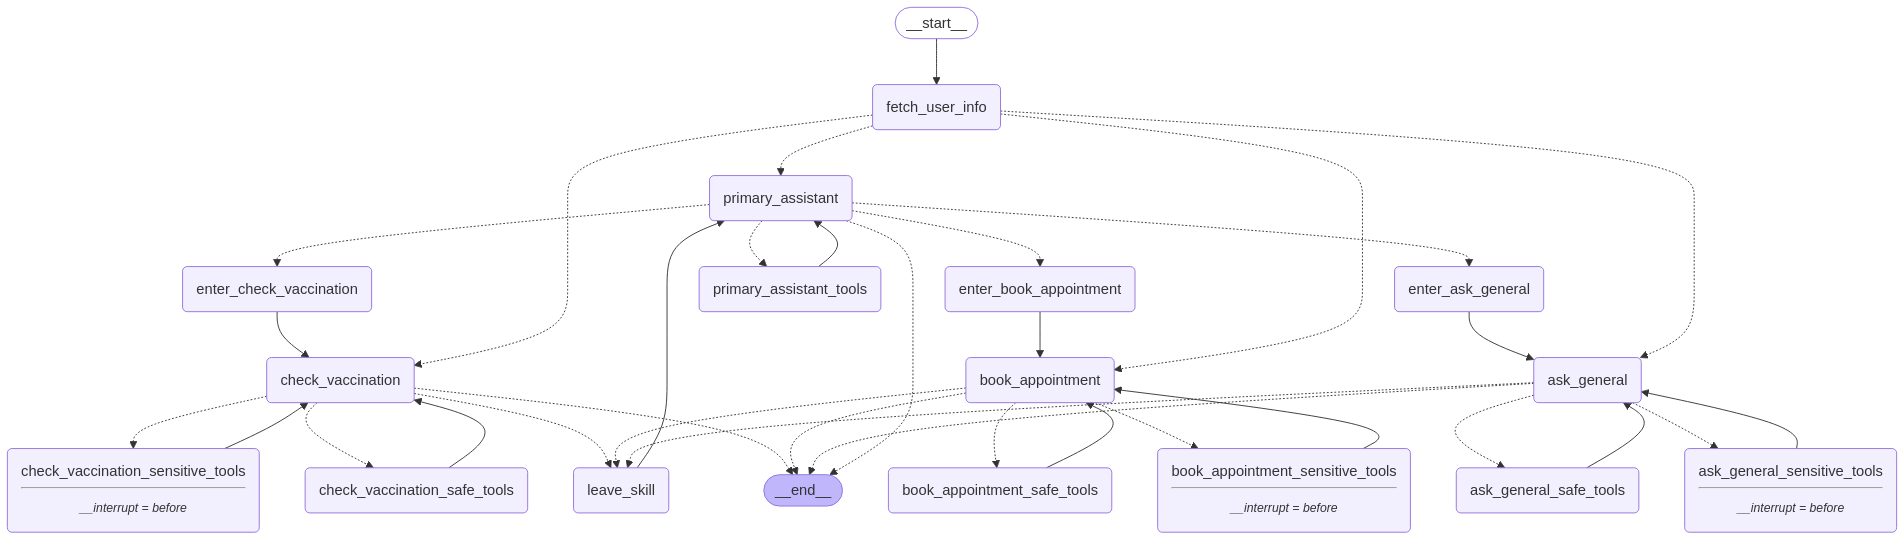

In [33]:
try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass